# Paired T-test

In [3]:
append_dict_path = "/datadrive/ruohan/final_results_list/append.dict"
residual_dict_path = "/datadrive/ruohan/final_results_list/residual.dict"

In [5]:
import scipy.stats as stats
import sys
sys.path.insert(0, '/home/jianx/search-exposure/active_metric_learning/')
from util import obj_reader
import numpy as np

In [16]:
def paired_t_test(path):
    results = obj_reader(path)
    baseline = results["baseline_nrbp"]
    model = results["model_nrbp"]
    base_list = np.array(list(baseline.values()))
    model_list = np.array(list(model.values()))
    statistic, p_value = stats.ttest_rel(model_list, base_list)
    print("Avg: Baseline {} Model {}".format(np.mean(base_list), np.mean(model_list)))
    print("T-statistic {} Two-sided p-value {}".format(statistic, p_value))
    print("One-sided p-value {}".format(p_value/2))

In [19]:
def test_append_residual(append_dict_path, residual_dict_path):
    append = np.array(list(obj_reader(append_dict_path)["model_nrbp"].values()))
    residual = np.array(list(obj_reader(residual_dict_path)["model_nrbp"].values()))
    statistic, p_value = stats.ttest_rel(residual, append)
    print("Avg: Append {} Residual {}".format(np.mean(append), np.mean(residual)))
    print("T-statistic {} Two-sided p-value {}".format(statistic, p_value))
    print("One-sided p-value {}".format(p_value/2))


In [24]:
print("Append vs. Baseline")
paired_t_test(append_dict_path)

Append vs. Baseline
Avg: Baseline 0.6852111699318101 Model 0.82544224058361
T-statistic 62.78156732211389 Two-sided p-value 0.0
One-sided p-value 0.0


In [25]:
print("Residual vs. Baseline")
paired_t_test(residual_dict_path)

Residual vs. Baseline
Avg: Baseline 0.6852111699318101 Model 0.8338437585651999
T-statistic 59.16810117664033 Two-sided p-value 0.0
One-sided p-value 0.0


In [26]:
print("Append vs. Residual")
test_append_residual(append_dict_path, residual_dict_path)

Append vs. Residual
Avg: Append 0.82544224058361 Residual 0.8338437585651999
T-statistic 5.2885123007282955 Two-sided p-value 1.2499395341008478e-07
One-sided p-value 6.249697670504239e-08


# Analyze probability of retrieval

In [6]:
import matplotlib.pyplot as plt

In [29]:
residual_results = obj_reader(residual_dict_path)
baseline_dict = residual_results['baseline_nrbp']
residual_dict = residual_results['model_nrbp']

In [30]:
diff_dict = {}
for qid, nrbp in residual_dict.items():
    diff_dict[qid] = nrbp-baseline_dict[qid]

In [135]:
diff_list = list(diff_dict.values())
sum(np.array(diff_list)>=0)

11864

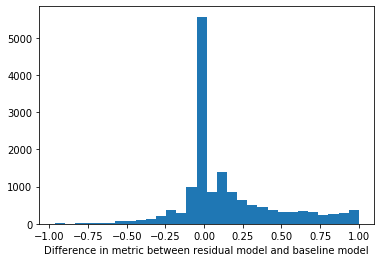

In [80]:
plt.hist(diff_list, bins=30)
plt.xlabel("Difference in metric between residual model and baseline model")
plt.show()

## Zipf's Law Plot

In [4]:
import sys
sys.path.insert(0, '/home/jianx/search-exposure/active_metric_learning/')
from util import obj_reader
from testing import load_true_dict, delete_zeros
results = obj_reader("/datadrive/ruohan/final_evaluation/no_active_residual_50000_query_200000_passage.dict")

In [5]:
true_dict_100 = load_true_dict(k=100)

In [140]:
def plot_zipf_log(results, true_dict):
    baseline_rank = results["forward_baseline_rank_test"]
    residual_rank = results["pred_rank_test"]  
    n = len(baseline_rank)
    base = []
    model = []
    true = []
    for pid, ranks in baseline_rank.items():
        base.append(np.log(max(len(delete_zeros(ranks)),1)))
        model.append(np.log(max(1,len(delete_zeros(residual_rank[pid])))))
        true.append(np.log(max(1,len(true_dict.get(pid, [])))))
    base = sorted(base, reverse=True)
    model = sorted(model, reverse=True)
    true = sorted(true, reverse=True)
    x_rank = [np.log(i) for i in range(1,n+1)]
    plt.plot(x_rank, true, label="Ground Truth Exposing Queries")
    plt.plot(x_rank, model, label="Exposing Queries Retrieved by Residual Model")
    plt.plot(x_rank, base, label="Exposing Queries Retrieved by Baseline Model")
    plt.hlines(np.log(100), np.log(1), np.log(n), linestyles='dashed', label="log(100)")
    plt.xlabel("log(rank)")
    plt.ylabel("log(count)")
    plt.legend()
    plt.savefig("log_log.pdf", dpi=1200)
    plt.show()

In [138]:
def plot_zipf(results, true_dict):
    baseline_rank = results["forward_baseline_rank_test"]
    residual_rank = results["pred_rank_test"]  
    n = len(baseline_rank)
    base = []
    model = []
    true = []
    for pid, ranks in baseline_rank.items():
        base.append(len(delete_zeros(ranks)))
        model.append(len(delete_zeros(residual_rank[pid])))
        true.append(len(true_dict.get(pid, [])))
    base = sorted(base, reverse=True)
    model = sorted(model, reverse=True)
    true = sorted(true, reverse=True)
    x_rank = [i for i in range(1,n+1)]
    plt.plot(x_rank, true, label="Ground Truth Exposing Queries")
    plt.plot(x_rank, model, label="Exposing Queries Retrieved by Residual Model")
    plt.plot(x_rank, base, label="Exposing Queries Retrieved by Baseline Model")
    plt.xlabel("Rank")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

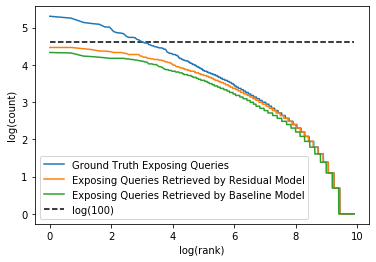

In [141]:
plot_zipf_log(results, true_dict_100)

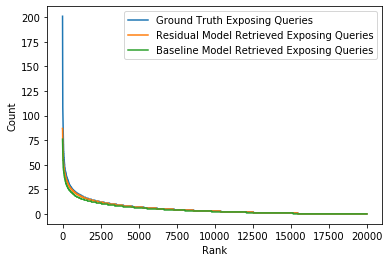

In [69]:
plot_zipf(results, true_dict_100)

# Analysis on exposing queries characteristics

In [47]:
from collections import Counter
import string
import matplotlib.pyplot as plt

In [7]:
def load_tsv_dict(path):
    with open(path) as file:
        line = file.readline()
        my_dict = {}
        while line:
            tokens = line.split("\t")
            indexid = int(tokens[0])
            text = tokens[1].rstrip()
            my_dict[indexid] = text
            line = file.readline()
    return my_dict

In [8]:
# Process all queries in the query log 
# to form bucket data
QUERIES_TEXT_PATH = "/datadrive/jianx/data/queries.train.tsv"
queries_text_dict = load_tsv_dict(QUERIES_TEXT_PATH)

In [36]:
def construct_df_dict(queries_text_dict):
    vocab = Counter()
    for qid, query in queries_text_dict.items():
        q = query.translate(str.maketrans('', '', string.punctuation))
        q = q.strip().split(" ")
        for word in set(q):
            vocab[word.lower()] += 1
    vocab = {k: v for k, v in sorted(vocab.items(), key=lambda item: item[1],reverse=True)}
    return vocab

In [37]:
vocab = construct_df_dict(queries_text_dict)

In [59]:
vocab["what"]

292433

In [43]:
def set_to_counter(query_len_dict, set_q):
    len_dict = Counter()
    for q in set_q:
        len_dict[query_len_dict[q]] += 1
    return len_dict

In [44]:
def plot_a_line(ex_dict, q_len_dict, label, cutoff=100):
    ex_dict = {k: v for k, v in sorted(ex_dict.items(), key=lambda item: item[0])}
    xaxis = []
    yaxis = []
    for length, count in ex_dict.items():
        if q_len_dict[length] < cutoff:
            continue
        xaxis.append(length)
        yaxis.append(count/q_len_dict[length])
    plt.plot(xaxis, yaxis, label=label)

In [45]:
def plot_query_length(queries_text_dict, results, true_dict, n):
    q_len_dict = Counter()
    query_len_dict = {}
    for qid, query in queries_text_dict.items():
        q = query.strip().split(" ")
        q_len_dict[len(q)] += 1
        query_len_dict[qid] = len(q)
    q_len_dict = {k: v for k, v in sorted(q_len_dict.items(), key=lambda item: item[0])}
    print(q_len_dict)
    baseline_rank = results["forward_baseline_rank_test"]
    residual_rank = results["pred_rank_test"]
    exposing_qs = set()
    base_qs = set()
    model_qs = set()
    for pid, qids in baseline_rank.items():
        base_q = list(qids.keys())[:n]
        model_q = list(residual_rank[pid].keys())[:n]
        base_qs.update(base_q)
        model_qs.update(model_q)
        true_q = true_dict.get(pid, None)
        if true_q:
            true_qq = list(true_q.keys())
            exposing_qs.update(true_qq)
    print(len(exposing_qs), len(base_qs), len(model_qs))
    expose_dict = set_to_counter(query_len_dict, exposing_qs)
    base_dict = set_to_counter(query_len_dict, base_qs)
    model_dict = set_to_counter(query_len_dict, model_qs)
    plot_a_line(expose_dict, q_len_dict, "Probability of exposing")
    plot_a_line(model_dict, q_len_dict, "Probability of retrieval by Residual model")
    plot_a_line(base_dict, q_len_dict, "Probability of retrieval by Baseline model")
    plt.legend()
    plt.xlabel("Query Length")
    plt.ylabel("Probability")
    plt.show()

{1: 35, 2: 16545, 3: 63354, 4: 117889, 5: 145157, 6: 135318, 7: 109186, 8: 79361, 9: 53216, 10: 33570, 11: 20557, 12: 12845, 13: 7928, 14: 4763, 15: 2998, 16: 1998, 17: 1257, 18: 817, 19: 540, 20: 308, 21: 304, 22: 187, 23: 141, 24: 117, 25: 80, 26: 55, 27: 48, 28: 38, 29: 29, 30: 20, 31: 16, 32: 14, 33: 13, 34: 5, 35: 2, 36: 5, 37: 3, 38: 4, 39: 1, 40: 1, 41: 1, 44: 1, 49: 1, 50: 1, 75: 1, 373: 1}
101282 120490 135883


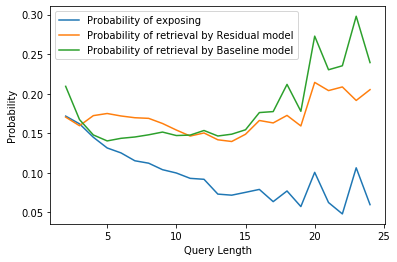

In [129]:
plot_query_length(queries_text_dict, results, true_dict_100, 10)

{1: 35, 2: 16545, 3: 63354, 4: 117889, 5: 145157, 6: 135318, 7: 109186, 8: 79361, 9: 53216, 10: 33570, 11: 20557, 12: 12845, 13: 7928, 14: 4763, 15: 2998, 16: 1998, 17: 1257, 18: 817, 19: 540, 20: 308, 21: 304, 22: 187, 23: 141, 24: 117, 25: 80, 26: 55, 27: 48, 28: 38, 29: 29, 30: 20, 31: 16, 32: 14, 33: 13, 34: 5, 35: 2, 36: 5, 37: 3, 38: 4, 39: 1, 40: 1, 41: 1, 44: 1, 49: 1, 50: 1, 75: 1, 373: 1}
101282 292539 345711


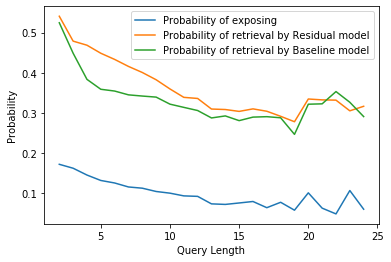

In [133]:
plot_query_length(queries_text_dict, results, true_dict_100, 50)

In [58]:
def plot_a_line_df(ex_dict, q_len_dict, label, bucket_size, cutoff=100):
    ex_dict = {k: v for k, v in sorted(ex_dict.items(), key=lambda item: item[0])}
    xaxis = []
    yaxis = []
    for length, count in ex_dict.items():
        if q_len_dict[length] < cutoff:
            continue
        xaxis.append(length * bucket_size+50)
        yaxis.append(count/q_len_dict[length])
    plt.plot(xaxis, yaxis, label=label)
    return xaxis, yaxis

In [57]:
def plot_query_df(queries_raw, results, true_dict, n, bucket_size, is_average):
    q_len_dict = Counter()
    query_len_dict = {}
    vocabs = Counter()
    for qid, query in queries_raw.items():
        q = query.translate(str.maketrans('', '', string.punctuation))
        q = q.strip().split(" ")
        for word in set(q):
            vocabs[word.lower()] += 1
    if is_average:
        for qid, query in queries_raw.items():
            q = query.strip().split(" ")
            df = 0
            for word in q:
                df += vocabs[word]
            df /= len(q)
            q_len_dict[df//bucket_size] += 1
            query_len_dict[qid] = df//bucket_size
    else:
        for qid, query in queries_raw.items():
            q = query.strip().split(" ")
            df =  float('inf')
            for word in q:
                df = min(vocabs[word],df)
            q_len_dict[df//bucket_size] += 1
            query_len_dict[qid] = df//bucket_size
    q_len_dict = {k: v for k, v in sorted(q_len_dict.items(), key=lambda item: item[0])}
    print(q_len_dict)
    baseline_rank = results["forward_baseline_rank_test"]
    residual_rank = results["pred_rank_test"]
    exposing_qs = set()
    base_qs = set()
    model_qs = set()
    for pid, qids in baseline_rank.items():
        base_q = list(qids.keys())[:n]
        model_q = list(residual_rank[pid].keys())[:n]
        base_qs.update(base_q)
        model_qs.update(model_q)
        true_q = true_dict.get(pid, None)
        if true_q:
            true_qq = list(true_q.keys())
            exposing_qs.update(true_qq)
    print(len(exposing_qs), len(base_qs), len(model_qs))
    expose_dict = set_to_counter(query_len_dict, exposing_qs)
    base_dict = set_to_counter(query_len_dict, base_qs)
    model_dict = set_to_counter(query_len_dict, model_qs)
    expose_x, expose_y = plot_a_line_df(expose_dict, q_len_dict, "Probability of exposing", bucket_size)
    model_x, model_y = plot_a_line_df(model_dict, q_len_dict, "Probability of retrieval by Residual model", bucket_size)
    base_x, base_y = plot_a_line_df(base_dict, q_len_dict, "Probability of retrieval by Baseline model", bucket_size)
    plt.legend()
    plt.xlabel("Query df, Bucket Size {}".format(bucket_size))
    plt.ylabel("Probability")
    return expose_x, expose_y, model_x, model_y, base_x, base_y

{0: 595702, 1: 96676, 2: 43433, 3: 25996, 4: 14554, 5: 8650, 6: 5901, 7: 4668, 8: 3094, 9: 2775, 10: 1300, 11: 1093, 12: 1107, 13: 592, 14: 365, 15: 264, 16: 351, 17: 535, 18: 307, 19: 197, 20: 247, 21: 87, 22: 198, 23: 104, 24: 60, 25: 48, 26: 57, 27: 23, 28: 12, 29: 35, 30: 32, 31: 12, 32: 14, 33: 40, 34: 10, 35: 2, 37: 11, 38: 5, 39: 19, 40: 16, 41: 15, 42: 8, 43: 6, 44: 8, 45: 5, 46: 2, 48: 6, 50: 30, 51: 1, 53: 3, 54: 7, 57: 2, 58: 2, 59: 4, 60: 2, 61: 3, 63: 3, 68: 9, 71: 1, 84: 6, 111: 1, 122: 1, 124: 1, 126: 2, 150: 3, 179: 1, 186: 2, 260: 2, 286: 1, 300: 2}
101282 120490 135883


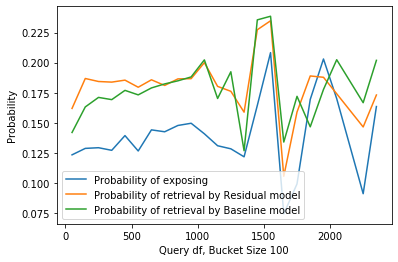

{0: 595702, 1: 96676, 2: 43433, 3: 25996, 4: 14554, 5: 8650, 6: 5901, 7: 4668, 8: 3094, 9: 2775, 10: 1300, 11: 1093, 12: 1107, 13: 592, 14: 365, 15: 264, 16: 351, 17: 535, 18: 307, 19: 197, 20: 247, 21: 87, 22: 198, 23: 104, 24: 60, 25: 48, 26: 57, 27: 23, 28: 12, 29: 35, 30: 32, 31: 12, 32: 14, 33: 40, 34: 10, 35: 2, 37: 11, 38: 5, 39: 19, 40: 16, 41: 15, 42: 8, 43: 6, 44: 8, 45: 5, 46: 2, 48: 6, 50: 30, 51: 1, 53: 3, 54: 7, 57: 2, 58: 2, 59: 4, 60: 2, 61: 3, 63: 3, 68: 9, 71: 1, 84: 6, 111: 1, 122: 1, 124: 1, 126: 2, 150: 3, 179: 1, 186: 2, 260: 2, 286: 1, 300: 2}
101282 366973 428876


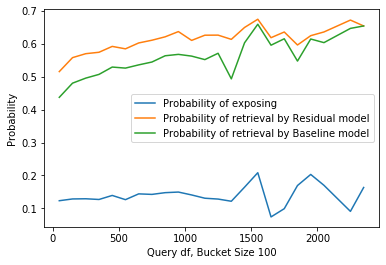

In [55]:
# plot_query_df(queries_text_dict, results, true_dict_100, 10, 1000, True)
# plt.savefig("/datadrive/jianx/plots/query_df_average")
# plt.show()
plot_query_df(queries_text_dict, results, true_dict_100, 10, 100, False)
plt.show()
plot_query_df(queries_text_dict, results, true_dict_100, 100, 100, False)
plt.show()
# plt.savefig("/datadrive/jianx/plots/query_df_min")

{0.0: 20635, 1.0: 12023, 2.0: 11186, 3.0: 8621, 4.0: 10801, 5.0: 5894, 6.0: 10297, 7.0: 9602, 8.0: 10424, 9.0: 7593, 10.0: 14964, 11.0: 5132, 12.0: 5465, 13.0: 3994, 14.0: 10207, 15.0: 5033, 16.0: 3616, 17.0: 4425, 18.0: 5642, 19.0: 4820, 20.0: 5092, 21.0: 5143, 22.0: 6213, 23.0: 7377, 24.0: 6106, 25.0: 7396, 26.0: 7764, 27.0: 7434, 28.0: 7546, 29.0: 7882, 30.0: 7434, 31.0: 10119, 32.0: 9015, 33.0: 7943, 34.0: 7873, 35.0: 7002, 36.0: 8744, 37.0: 9160, 38.0: 8877, 39.0: 7490, 40.0: 8503, 41.0: 8233, 42.0: 9633, 43.0: 8109, 44.0: 7780, 45.0: 8769, 46.0: 8612, 47.0: 7773, 48.0: 8114, 49.0: 7284, 50.0: 9757, 51.0: 8803, 52.0: 8843, 53.0: 8492, 54.0: 6392, 55.0: 7733, 56.0: 6309, 57.0: 7033, 58.0: 9138, 59.0: 6683, 60.0: 6899, 61.0: 6547, 62.0: 6819, 63.0: 6830, 64.0: 5328, 65.0: 6127, 66.0: 5635, 67.0: 6666, 68.0: 5025, 69.0: 5301, 70.0: 4423, 71.0: 3764, 72.0: 11758, 73.0: 7570, 74.0: 5283, 75.0: 6172, 76.0: 5369, 77.0: 3336, 78.0: 3430, 79.0: 3729, 80.0: 3765, 81.0: 5933, 82.0: 3760, 83.

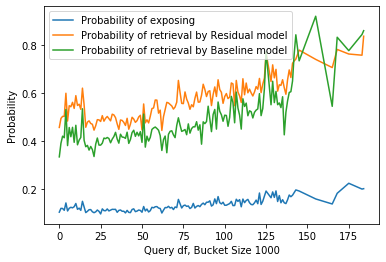

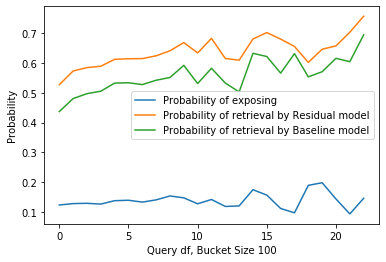

In [30]:
plot_query_df(queries_text_dict, results, true_dict_100, 100, 1000, True)
plt.savefig("/datadrive/jianx/plots/query_df_average_100.pdf")
plt.show()
plot_query_df(queries_text_dict, results, true_dict_100, 100, 100, False)
plt.savefig("/datadrive/jianx/plots/query_df_min_100.pdf")

## Position of Exposing Queries